# Karplus-Strong Plucked String Synthesis

The Karplus-Strong plucked string instrument synthesis algorithm was originally published in 1984. This algorithm belongs to a family of synthesis algorithms known as *waveguide synthesis*, which itself is based on wavetable synthesis.

Let's start with wavetable synthesis.

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
from IPython.display import Audio
from numpy.fft import fft, ifft
%matplotlib inline

fs = 44100 

# code for example wavetable generation was lifted from https://flothesof.github.io/Karplus-Strong-algorithm-Python.html
# following code is written while following the above tutorial
def make_sine_wavetable(n_samples, amps, phases, freqs):
    """Makes a wavetable from a sum of sines."""
    t = np.linspace(0, 1, num=n_samples)
    wavetable = np.zeros_like(t)
    for amp, phase, freq in zip(amps, phases,freqs):
        wavetable += amp * np.sin(np.sin(2 * np.pi * freq * t + phase)) + \
                         amp / 2 * np.sin(np.sin(2 * np.pi * 2 * freq * t + phase))
    return wavetable

Given an array of samples defining a waveform, we can create a new waveform by undersampling it and returning back to the beginning of the wavetable when we reach the end. We implement this using a "slow" and "fast" pointer:

In [28]:
def wavetab_synthesize(rate, wavetable, n_samples):
    samples = []
    current_sample = 0
    # could probably try to vectorize this, but I'm aiming for precomputation anyways
    while len(samples) < n_samples:
        current_sample += rate
        current_sample = current_sample % wavetable.size
        samples.append(wavetable[current_sample])
        current_sample += 1
    return np.array(samples)

In [29]:
'''sample1 = wavetab_synthesize(220, wavetable, 2 * fs)
sample2 = wavetab_synthesize(440, wavetable, 2 * fs)

x = np.arange(300); plt.plot(x, sample1[0:300]); plt.show
x = np.arange(300); plt.plot(x, sample2[0:300]); plt.show
plt.xlabel('sample number')

Audio(sample2, rate=fs)'''

"sample1 = wavetab_synthesize(220, wavetable, 2 * fs)\nsample2 = wavetab_synthesize(440, wavetable, 2 * fs)\n\nx = np.arange(300); plt.plot(x, sample1[0:300]); plt.show\nx = np.arange(300); plt.plot(x, sample2[0:300]); plt.show\nplt.xlabel('sample number')\n\nAudio(sample2, rate=fs)"

The classic Karplus-Strong algorithm starts with an excitation signal that consists of randomly-generated 1s and -1s (effectively, a wavetable containing noise). Then, the envelope of the waveform is determined by averaging the previous two samples at each sample. As written in the paper:

$$Y_t = \frac{1}{2}(Y_{t-p} + Y_{t-p-1})$$

Where $Y_t$ is the level at sample $t$.  

This effectively simulates decay by gradually forcing the samples towards 0 (this can be guaranteed by randomly distributing 1s and -1s in the excitation signal). Periodicity is introduced by looping back through the excitation signal while generating the plucked string audio. Therefore, the tone produced can be controlled by changing the length of the excitation signal.

In [30]:
def karplus_strong(wavtab, n_samples):
	samples = []
	t = 0

	# there is probably a closed form for this equation but I'm going to ignore that for now
	# this is effectively a delay line of length equal to len(wavtab)
	while len(samples) < n_samples:
		previous_value = wavtab[t - 1] if len(samples) > 1 else 0
		wavtab[t] = 0.5 * (wavtab[t] + previous_value)
		samples.append(wavtab[t])
		t = (t + 1) % len(wavtab)
	
	return np.array(samples)

<function matplotlib.pyplot.show(close=None, block=None)>

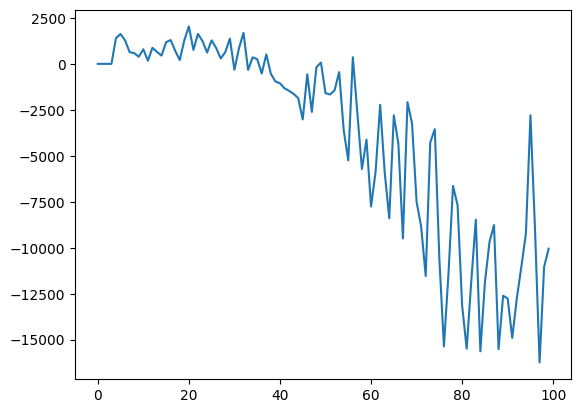

In [32]:
# generate random excitation signal
numsecs = 2
fundamental = 440
ks_wavtab_size = fs // fundamental # integer division
wavetable = (2 * np.random.randint(0, 2, ks_wavtab_size) - 1).astype(np.float32)

excite_sig_filename = "data/Cembalo-Excitation-Midtone.wav"
f_s, excite_sig_raw = wavfile.read(excite_sig_filename)
wavetable = excite_sig_raw[0:ks_wavtab_size]

x = np.arange(100); plt.plot(x, wavetable[0:100]); plt.show

Above we see the random excitation signal. Now, we feed this signal through the Karplus-Strong algorithm and plot a close-up view of the waveform.

In [33]:
pluck = karplus_strong(wavetable, 2 * fs)
Audio(pluck, rate = fs)

(0.0, 1000.0)

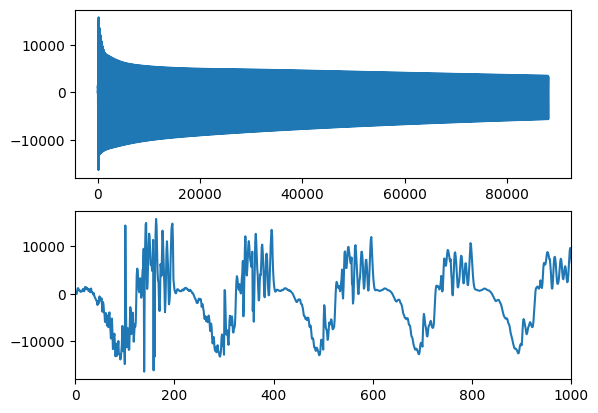

In [ ]:
# plots of the resulting plucked-string waveform
plt.subplot(211) # why is plt like this -_-
plt.plot(pluck)
plt.subplot(212)
plt.plot(pluck)
plt.xlim(0, 1000)